# Visualization of data from Elhub
Source <https://elhub.no/statistikk/>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
df_produksjon= pd.read_excel('https://elhub.no/app/uploads/2023/06/Daglig-produksjon-pr-type-og-prisomrade-MWh-1.xlsx')
df_loss = pd.read_excel('https://elhub.no/app/uploads/2023/06/Daglig-nettap-pr-prisomrade-MWh-1.xlsx')
df_group = pd.read_excel('https://elhub.no/app/uploads/2023/06/Daglig-forbruk-pr-gruppe-og-prisomrade-MWh-1.xlsx')
#df_produksjon = df_produksjon.rename(columns=df_produksjon.iloc[0]).drop(df_produksjon.index[0])
#df_group = df_group.rename(columns=df_group.iloc[0]).drop(df_group.index[0])

In [3]:
#Wrangle production data
df_produksjon.rename(columns={
    'Bruksdøgn':'dato',
    'Produksjonstype':'produksjonstype',
    'Prisområde':'region',
    'Volum (MWh)': 'volum'
}, inplace = True)
df_produksjon = df_produksjon.astype({'volum':'int64',
                'region':'category',
                'produksjonstype': 'category',
                'dato': 'datetime64'})

## Wrangle transmission loss data
df_loss.rename(columns={
    'Bruksdøgn':'dato',
    'Prisområde':'region',
    'Fysisk Nettap':'fysisk_tap',
    'Administrativt Nettap': 'admin_tap'
}, inplace = True)
df_loss = df_loss.astype({'region':'category',
                'admin_tap':'int64',
                'fysisk_tap': 'int64',
                'dato': 'datetime64'})
##Wranlge consumption data
df_group.rename(columns={
    'STARTDATE':'dato',
    'MBA':'region',
    'GROUPDESCRIPTION':'gruppe',
    'VOLMWH': 'volum',
    'ANTMP': 'antall_konsumenter'
}, inplace = True)
df_group = df_group.astype({'region':'category',
                'volum':'int64',
                'dato': 'datetime64',
                'gruppe':'category'})

##Correct for outlier in NO3 21. july 2021
median_termal = df_produksjon.loc[(df_produksjon['region'] == 'NO3') & (df_produksjon['produksjonstype'] == 'Termisk kraft')].volum.median()
df_produksjon.loc[(df_produksjon['region'] == 'NO3') & (df_produksjon['produksjonstype'] == 'Termisk kraft')& (df_produksjon['dato'] == '2020-07-21'), 'volum'] = median_termal
median_gruppe = df_group.loc[(df_group['region'] == 'NO3') & (df_group['gruppe'] == 'Elektrisitets-, gass-, damp- og varmtvannsforsyning')].volum.median()
df_group.loc[(df_group['region'] == 'NO3') & (df_group['dato'] == '2020-07-21') & (df_group['gruppe'] == 'Elektrisitets-, gass-, damp- og varmtvannsforsyning'), 'volum'] = median_gruppe
### Add transmission loss as percentage of consumption
#df_prod_volum = df_produksjon.groupby(['dato', 'region'])[['volum']].sum().reset_index()
#df_loss = pd.merge(df_loss, df_prod_volum, how='left', left_on=['dato','region'], right_on=['dato','region'])
#df_loss.rename(columns= {'volum': 'prod_volum'}, inplace= True)

Filter data after choosen regions

In [4]:
options = ['NO1']
length = len(options)
if length == 0:
    print('Choose at least one region')
elif length == 1:
    df_produksjon_filter = df_produksjon[df_produksjon['region'] == options[0]]
    #df_loss_filter = df_loss[df_loss['region'] == options[0]]
    #df_loss_filter['fysisk_tap_andel'] = df_loss_filter['fysisk_tap']/df_loss_filter['prod_volum']
    df_group_filter = df_group[df_group['region'] == options[0]]
else:
    df_produksjon_filter = df_produksjon[df_produksjon['region'].isin(options)] # Filter for choosen regions
    df_produksjon_filter =df_produksjon_filter.groupby(['dato', 'produksjonstype'])[['volum']].sum().reset_index() # Aggregate data
    #df_loss_filter = df_loss[df_loss['region'].isin(options)] 
    #df_loss_filter = df_loss_filter.groupby(['dato'])[['fysisk_tap','admin_tap','prod_volum']].sum().reset_index() 
    #df_loss_filter['fysisk_tap_andel'] = df_loss_filter['fysisk_tap']/df_loss_filter['prod_volum']
    df_group_filter = df_group[df_group['region'].isin(options)] 
    df_group_filter = df_group_filter.groupby(['dato','gruppe'])[['volum','antall_konsumenter']].sum().reset_index() 


In [7]:
df_produksjon_filter.groupby(['dato'])[['volum']].max().reset_index().ord('volum')

,dato,volum
0,2020-01-01,43328
1,2020-01-02,42475
2,2020-01-03,42042
3,2020-01-04,38595
4,2020-01-05,49480
...,...,...
1242,2023-05-27,60343
1243,2023-05-28,57871
1244,2023-05-29,61973
1245,2023-05-30,64419


# Make plots 

In [23]:
fig_prod = px.line(df_produksjon_filter,x = 'dato', y = 'volum', color= 'produksjonstype',template="plotly_white",title="Production by source")
fig_prod.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
}, showlegend=False, yaxis_title="Volume [Mwh]")


fig_group = px.line(df_group_filter, x = 'dato', y= ['volum'], color= 'gruppe', template= 'plotly_white', title= 'Consumption by group' )
fig_group.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
}, showlegend=False, yaxis_title="Volume [Mwh]")

#subfig = make_subplots(specs=[[{"secondary_y": True}]])
#fig1 = px.line(df_loss_filter, x = 'dato', y= ['fysisk_tap','admin_tap'], template= 'plotly_white')
#fig2 = px.line(df_loss_filter, x = 'dato', y= ['fysisk_tap_andel'], template= 'plotly_white')
#fig2.update_traces(yaxis="y2",line_color='#DC3912')
#subfig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
#'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#}, showlegend=False, title_text = 'Transmisjonstap <br><sup>Rød linje er andel av produksjon, akse til høyre</sup>')
#subfig.add_traces(fig1.data + fig2.data)

NameError: name 'df_produksjon_filter' is not defined

## Check coreltion between wind production and consumption

In [63]:
df_produksjon = df_produksjon.groupby(['dato', 'produksjonstype'])[['volum']].sum().reset_index()
vindprod = df_produksjon[df_produksjon['produksjonstype'] == 'Vindkraft'].reset_index()
vindprod.rename(columns = {'volum': 'vindkraft'}, inplace = True)
consumption = df_group.groupby('dato')[['volum']].sum()
consumption.rename(columns = {'volum': 'consumption'}, inplace = True)
df = consumption.merge(vindprod, on = 'dato')
df.drop(['index','produksjonstype'], axis = 1, inplace= True)

In [91]:
df.corr()
df[df['dato'] > '2021-12-31'].corr()

,consumption,vindkraft
consumption,1.000000,0.378432
vindkraft,0.378432,1.000000


,consumption,vindkraft
consumption,1.000000,0.486033
vindkraft,0.486033,1.000000


In [102]:
fig = px.scatter(df[df['dato'] > '2021-12-31'], x="consumption", y="vindkraft", marginal_x="histogram", marginal_y="histogram", template= "plotly_white", trendline="ols")
fig.show()

<AxesSubplot:xlabel='consumption', ylabel='vindkraft'>

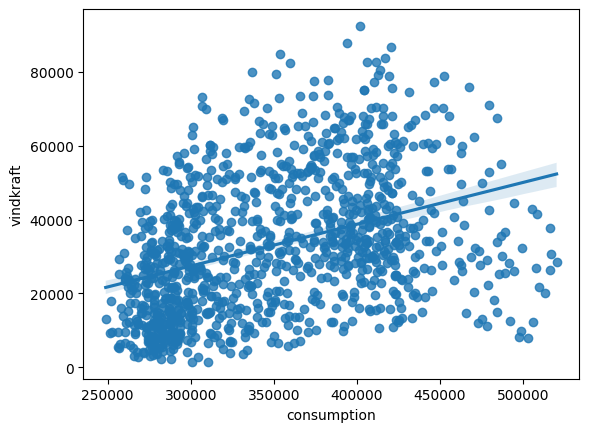

In [105]:
import seaborn as sns
sns.regplot(x = 'consumption',y = 'vindkraft', data = df, ci=95)

TypeError: regplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

In [83]:
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer
m1 = sm.ols(formula = 'consumption ~ vindkraft', data = df).fit()
Stargazer([m1])